In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random

import numpyro.distributions as dist 

import matplotlib.pyplot as plt

/Users/peng/miniforge3/envs/numpyro/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


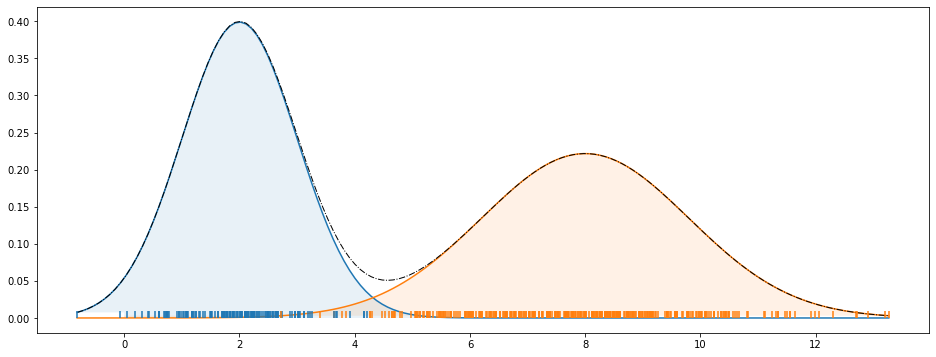

In [2]:
# draw samples from 2 Gaussian with probability z_i ~ bernoulli(0.75)
m1_key, m2_key = random.split(random.PRNGKey(654))
z_i = dist.Bernoulli(probs=0.75).sample(key=m1_key, sample_shape=(500,))
loc = jnp.array([2., 8.])
scale = jnp.array([1., 1.8])
x_i = dist.Normal(loc=loc[z_i], scale=scale[z_i]).sample(key=m2_key)

# plot generated data adn the latent distributions
x = jnp.linspace(x_i.min(), x_i.max(), 150)
plt.figure(figsize=(16,6))
plt.plot(x, jnp.exp(dist.Normal(loc=loc[0], scale=scale[0]).log_prob(x)))
plt.plot(x, jnp.exp(dist.Normal(loc=loc[1], scale=scale[1]).log_prob(x)))
plt.plot(x, jnp.exp(dist.Normal(loc=loc[1], scale=scale[1]).log_prob(x)) + \
    jnp.exp(dist.Normal(loc=loc[0], scale=scale[0]).log_prob(x)), lw=1, ls="-.", color="black")
plt.fill_betweenx(jnp.exp(dist.Normal(loc=loc[0], scale=scale[0]).log_prob(x)), x, alpha=0.1)
plt.fill_betweenx(jnp.exp(dist.Normal(loc=loc[1], scale=scale[1]).log_prob(x)), x, alpha=0.1)
plt.vlines(x_i, 0, 0.01, color=np.array(["C0","C1"])[z_i])

log-likelihood of the model:
$$
\begin{aligned}
l(\theta) &= \sum_{i=1}^n log(x_i; \theta)\\
&=\sum_{i=1}^nlog\sum_{k=1}^K p(x_i|z_k, \theta)p(z_k, \theta)
\end{aligned}$$

but Z is unobserved, the log-likelihood function has no closed form for the maximum likelihood

EM algorithm: Expectation Maximization, we guess Z and iteratively try to maximize the log-likelihood

**E-step**: Given a set of initialized chosen parameters we determine $w_{ij}$ for each data point.
$$w_{ij}:=p(z_i=j|x_i,\theta)$$
Asking the questions, what is the likelihood of data point x_i, being assigned to Gaussian j.

**M-step**: a likelihood ($w_{ij}$) weigted step
$$\phi_j := \frac{1}{n}\sum_{i=1}^n w_{ij} \\
\mu_j := \frac{\sum_{i=1}^n w_{ij}x_i}{\sum_{i=1}^n w_{ij}} \\
\sigma_{ij} := \sqrt{\frac{\sum_{i=1}^n w_{ij}(x_i - \mu_j)}{\sum_{i=1}^n w_{ij}}}$$

In [3]:
def e_step(data, mu, sigma, phi=None, k=2):
    if phi is None:
        phi = jnp.ones(k) / k
    wt = jnp.empty(data.shape)
    for i in range(k):
        wt_i = jnp.exp(dist.Normal(loc=mu[i], scale=sigma[i]).log_prob(data)) * phi[i]
        wt = jnp.vstack([wt, wt_i])
    wt = wt[1:]
    # normalization
    wt /= wt.sum(0)
    
    return wt

def m_step(data, mu, sigma, wt, k=2):
    phi = wt.mean(1)
    mu  = (wt * data).sum(1) / wt.sum(1)
    sigma = jnp.sqrt(((jnp.vstack([data, data]).T - loc)**2 * wt.T).sum(0) / wt.sum(1))
    return mu, sigma, phi

In [4]:
n_iter = 5000
phi = None 
loc_test = random.uniform(random.PRNGKey(42), shape=(2,), 
                          minval=x_i.min(), maxval=x_i.max())
scale_test = jnp.array([1., 0.5])
for i in range(n_iter):
    wt = e_step(x_i, mu=loc_test, sigma=scale_test, phi=phi)
    loc_test, scale_test, phi = m_step(x_i, loc_test, scale_test, wt)
    if i % (n_iter/5) == 0:
        print(loc_test, scale_test, phi)

[2.630356 8.344344] [1.637405  1.6332623] [0.37215787 0.6278421 ]
[1.8763834 7.8495827] [0.859085  1.9676256] [0.27317762 0.72682244]
[1.8763834 7.8495827] [0.859085  1.9676256] [0.27317762 0.72682244]
[1.8763834 7.8495827] [0.859085  1.9676256] [0.27317762 0.72682244]
[1.8763834 7.8495827] [0.859085  1.9676256] [0.27317762 0.72682244]


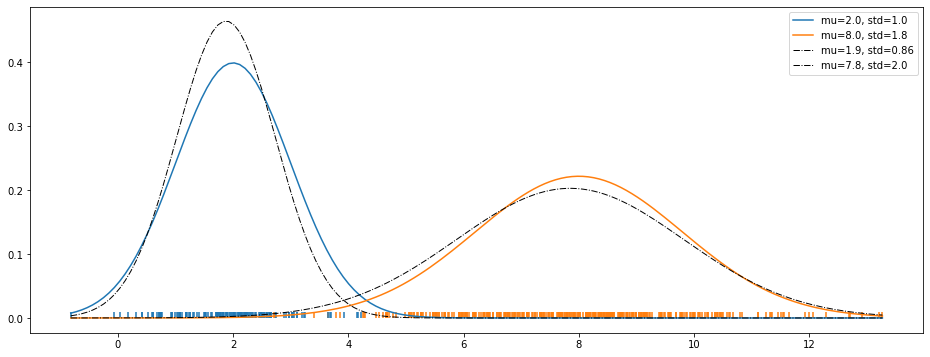

In [5]:
plt.figure(figsize=(16,6))
plt.vlines(x_i, 0, 0.01, color=np.array(["C0","C1"])[z_i])
x = jnp.linspace(x_i.min(), x_i.max(), 150)
plt.plot(x, jnp.exp(dist.Normal(loc=loc[0], scale=scale[0]).log_prob(x)),
         label=f"mu={loc[0]:.2}, std={scale[0]:.2}")
plt.plot(x, jnp.exp(dist.Normal(loc=loc[1], scale=scale[1]).log_prob(x)),
         label=f"mu={loc[1]:.2}, std={scale[1]:.2}")

plt.plot(x, jnp.exp(dist.Normal(loc=loc_test[0], scale=scale_test[0]).log_prob(x)), 
         ls="-.", lw=1, color="black",
         label=f"mu={loc_test[0]:.2}, std={scale_test[0]:.2}")
plt.plot(x, jnp.exp(dist.Normal(loc=loc_test[1], scale=scale_test[1]).log_prob(x)), 
         ls="-.", lw=1, color="black",
         label=f"mu={loc_test[1]:.2}, std={scale_test[1]:.2}")
plt.legend()